## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# calibration image
img_orig = cv2.imread('camera_cal/calibration3.jpg')
img = img_orig.copy()
undist = img_orig.copy()
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Find the chessboard corners
gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY) 
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

# calibrate camera
ret2,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)

#undistort
undist = cv2.undistort(img, mtx, dist, None, mtx)
 
#cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)

src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
offset = 100
img_size = (gray.shape[1], gray.shape[0])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, img_size)



# Plot the Warped Chessboard

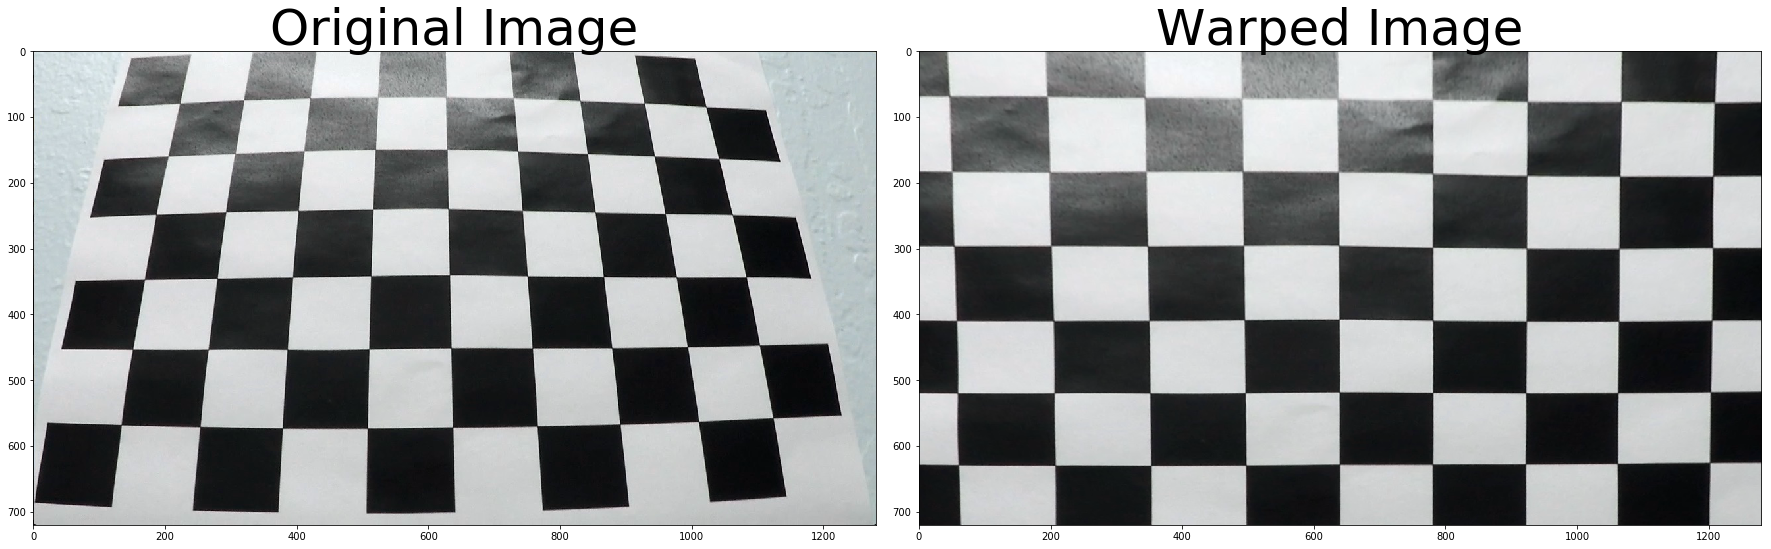

In [2]:
# Draw and display the corners

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orig)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
def unwarp(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

# Pipeline (Test Images)

## Unwarp and Undistort Test Images

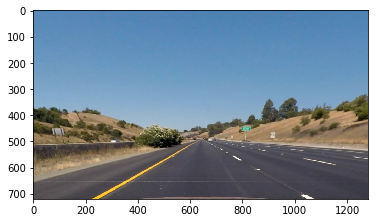

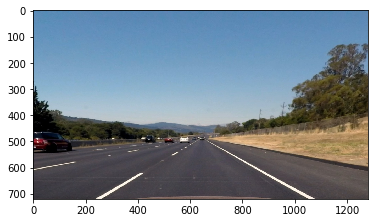

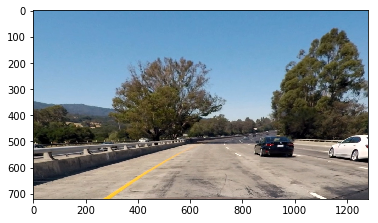

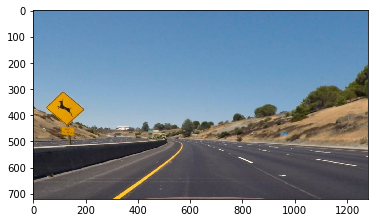

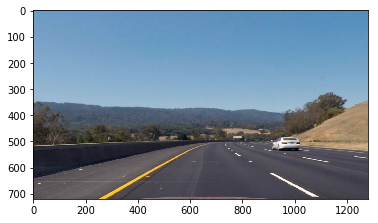

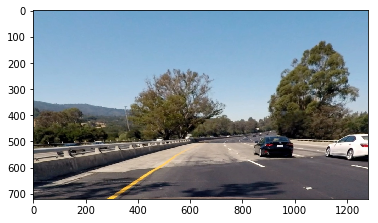

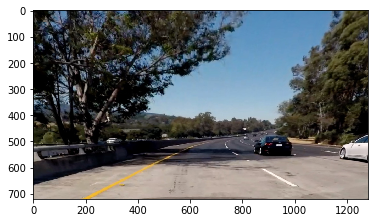

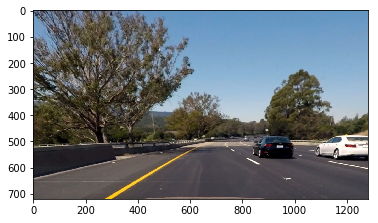

In [4]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    plt.figure(fname)
    plt.imshow(unwarp(test_img,mtx,dist))

#  Use color transforms, gradients or other methods to create a thresholded binary image.

In [5]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(150, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(100, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return gradx,grady,mag_binary,dir_binary,combined 



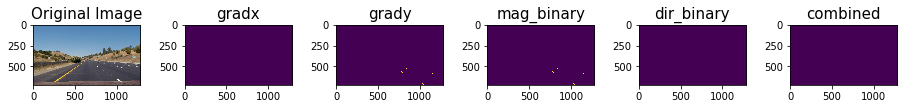

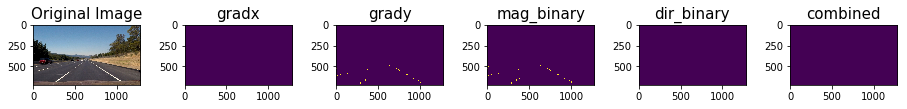

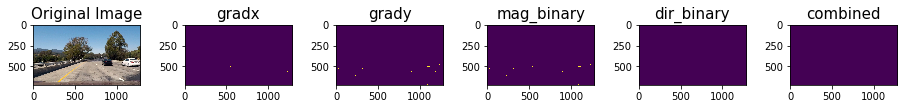

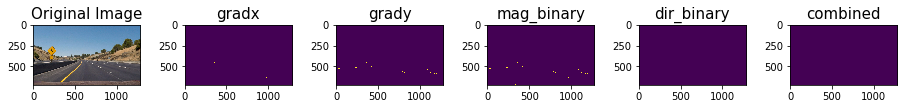

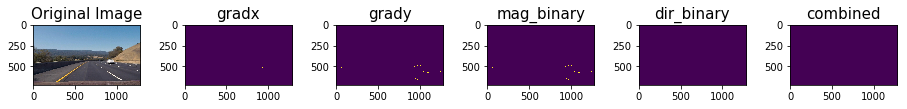

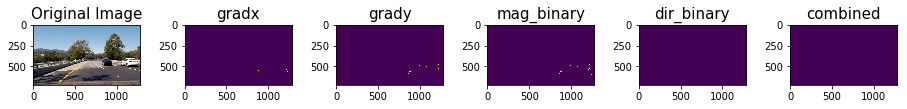

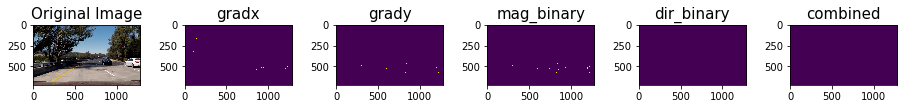

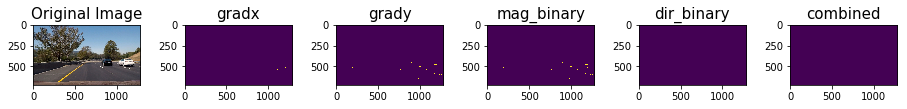

In [6]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img = unwarp(test_img,mtx,dist)

    gradx,grady,mag_binary,dir_binary,combined = pipeline(test_img)
    plt.figure(fname)
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_img_orig)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(gradx)
    ax2.set_title('gradx', fontsize=15)
    ax3.imshow(grady)
    ax3.set_title('grady', fontsize=15)
    ax4.imshow(mag_binary)
    ax4.set_title('mag_binary', fontsize=15)
    ax5.imshow(dir_binary)
    ax5.set_title('dir_binary', fontsize=15)
    ax6.imshow(combined)
    ax6.set_title('combined', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)